<a href="https://colab.research.google.com/github/sxy2996534527/ADM_project/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been prepared by Fabien Moutarde and Guillaume Devineau from MINES ParisTech.

NOTE: For the colab version of the notebook please make sure that you are using python3 and a **GPU accelerated backend** (select *GPU* as Hardware accelerator either in the *Edit > Notebook settings* or in the *Runtime > Change runtime type* menus for the english colab interface, or in the *Execution > Modifier le type d'exécution* menus for the french colab interface).

# Deep-Learning with Convolutional Neural Networks : Transfer Learning

## 1. Introduction

### 1.1 Convolutional Neural Network (CNN)

Convolutional Neural Networks (ConvNets) are powerful tools to create a mapping between an input domain, e.g. images, and an output domain, e.g. classes associated with the images.

Creating effective neural networks for a given task requires design choices, which include the network topology, the optimization procedure and the regularization. This is time consuming and requires expert input. For this reason, people tend to use <i>(de facto)</i> standard neural networks already known to be effective for a given task.

In this session, we will use a neural network, called **Inception v3** <code>[1]</code>, to classify images. The architecture of the Inception network is presented below.

<img src="https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png" alt="Inception" width="95%" />

<code>[1] https://arxiv.org/pdf/1512.00567.pdf</code>

### 1.2. Transfer Learning

In order not to spend the whole practical session staring at the screen while the network is training, we will not train the network from scratch but we will rather take a different approach called **Transfer Learning**.

When a model is trained on a given dataset for a given task, a knowledge useful for the task is accumulated. Transfer Learning is based on the hypothesis that this knowledge can -mostly- be reused for another similar dataset or task. In practice, this assumption is verified in a lot of cases.

** Transfer learning is partcularly powerful when re-using a convNet pre-trained for image classification on the huge and general ImageNet dataset. This is because it has learnt and "stored" in its lower layers a very GENERAL-PURPOSE transformation of images into a hierarchy of features. This learnt transformation is general enough to be used as a foundation onto which one can stack new layers for EASILY LEARNING ANY FUNCTION OF IMAGES: categorization for totally different classes, regression of camera pose, etc... Moreover, because the re-used layers transform input images into a very "pertinent" feature space, transfer learning make it possible to learn WITH VERY FEW EXAMPLES PER CLASS (and rather few epochs of training), as illustrated on the plot below.**

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_LSML/TP_TransferLearning-ConvNet/transfer-learning_Caltech-veryFewExamplesPerClass.png) 

** The goal of this practical session is precisely to allow you to reproduce and check by yourself the above result.**

## 2. Code

The notebook should work fine with both python 2 and python 3. If you have both, use python 3.

In [0]:
import sys
print('Your python version: {}'.format(sys.version_info.major))

### 2.1. (In case of emergency)

The notebook should run smoothly, but in case of a missing module (<code>ImportError: No module named your_missing_module</code>), uncomment the cell below (comments start with a <code>#</code>) to install the python pip modules needed.

In [0]:
#!{sys.executable} -m pip install -U keras --user
#!{sys.executable} -m pip install -U np_utils --user
!{sys.executable} -m pip install -U h5py --user  
#!{sys.executable} -m pip install -U matplotlib --user
#!{sys.executable} -m pip install -U seaborn --user
#!{sys.executable} -m pip install -U scipy --user
#!{sys.executable} -m pip install -U pygpu --user
#!{sys.executable} -m pip install -U six --user
#!{sys.executable} -m pip install -U tensorflow --user      # CPU-only version
#!{sys.executable} -m pip install -U tensorflow-gpu --user  # GPU version

### 2.2. Imports

Let's import every module we'll use later.

In [0]:
USE_TENSORFLOW_AS_BACKEND = True

In [0]:
%matplotlib inline
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn

In [0]:
if USE_TENSORFLOW_AS_BACKEND:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
else:
    os.environ['KERAS_BACKEND'] = 'theano'

In [0]:
import keras
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils

In [0]:
if USE_TENSORFLOW_AS_BACKEND:
    K.set_image_dim_ordering('tf')
else:
    K.set_image_dim_ordering('th')

Display the version of your modules (this notebook has successfully been tested with keras version 2.2.4 and tensorflow version 1.12.0. for instance).

In [0]:
print('Your keras version: {}'.format(keras.__version__))
if USE_TENSORFLOW_AS_BACKEND == True:
    import tensorflow
    print('Your tensorflow version: {}'.format(tensorflow.__version__))
else:
    import theano
    print('Your theano version: {}'.format(theano.__version__))

## 3. Dataset

We use a small image dataset called <code>CalTech 101 dataset</code> : it consists of pictures of objects belonging to 101 categories, with about 40 to 800 images per category; most categories have about 50 images.

### 3.1. Data download (optional)

<b>Skip this subsection if your are working on a MINES ParisTech self-service machine</b>, as the dataset is already downloaded on MINES ParisTech self-service machines.

Otherwise, download the dataset on your own latop download this archive (*): http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz and extract it. For convenience, the dataset can also be  <a href=101_ObjectCategories.tar.gz> downloaded locally from here</a>.

In [0]:
# --- only if you are on your own laptop ---

# Uncomment to download the dataset
# ...on Mines ParisTech computers:
#!wget "http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz" 
# ... or on google colab:
![[ -f 101_ObjectCategories.tar.gz ]] || wget "http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz"

# Uncomment to extract the dataset
# ...on Mines ParisTech computers:
#!tar xzf 101_ObjectCategories.tar.gz
# ... or on google colab:
![[ -f 101_ObjectCategories ]] || tar xzf 101_ObjectCategories.tar.gz

# Display files
!ls 101_ObjectCategories

Finally, <b>you should also change the value of</b> <code>dataset_path</code> in the <code>get_data()</code> function in code-cell below (section 3.2.) to include the correct path to the dataset you downloaded and extracted.

### 3.2. Data preprocessing

Quick functions to load the data:

In [0]:
def load_batch_images(path, n_examples_train, n_examples_validation=2, max_imgs_by_class=30, nb_categories=4, resize_to_size=(224,224)):

    images_train = []
    labels_train = []
    images_validation = []
    labels_validation = []
    
    # Get categories
    categories_list = os.listdir(path)
    categories_list = [category for category in categories_list if category != '.DS_Store']
    if isinstance(nb_categories, int) and len(categories_list) >= nb_categories:
        categories_list = categories_list[0:nb_categories]

    # For each category...
    for idx, category in enumerate(categories_list):
        # ... get images in category ...
        images_list = os.listdir(os.path.join(path, category))        
        if len(images_list) > max_imgs_by_class:
            images_list = images_list[:max_imgs_by_class]
        
        indx = 0
        for images in images_list[:n_examples_train + n_examples_validation]:                
            # ... load them ...
            img = load_img(os.path.join(path, category, images))  # as PIL images
            img = img_to_array(img)                               # as numpy array
            img = misc.imresize(img, resize_to_size)              # resize
            # img = misc.imrotate(img, 180)
            if indx < n_examples_train:
                images_train.append(img)
                labels_train.append(idx)
            else:
                images_validation.append(img)
                labels_validation.append(idx)
            indx += 1
    
    # Convert to one-hot
    labels_train = np_utils.to_categorical(labels_train)
    labels_validation = np_utils.to_categorical(labels_validation)

    return images_train, labels_train, images_validation, labels_validation

In [0]:
def shuffle_dataset(a, b):
    """Shuffle the entire dataset"""
    assert np.shape(a)[0] == np.shape(b)[0]
    p = np.random.permutation(np.shape(a)[0])
    return (a[p], b[p])

In [0]:
def get_data(samples_by_category=8, dataset_path="./101_ObjectCategories/", nb_categories=4):
    # NB: the dataset_path ABOVE SHOULD BE CORRECTED TO THE *ACTUAL PATH* WHERE YOU HAVE EXTRACTED 101_ObjectCategories
    images_train, labels_train, images_validation, labels_validation = load_batch_images(path=dataset_path, n_examples_train=samples_by_category, n_examples_validation=20, max_imgs_by_class=30, nb_categories=nb_categories)

    images_train = np.float64(images_train)
    images_validation = np.float64(images_validation)

    images_train = preprocess_input(images_train)  # substract the mean RGB channels of the imagenet dataset. This is because the Inception model we are using has been trained on a different dataset (imagenet dataset)
    images_validation = preprocess_input(images_validation)

    if not USE_TENSORFLOW_AS_BACKEND:
        images_validation = images_validation.swapaxes(1, 3).swapaxes(2, 3)
        images_train = images_train.swapaxes(1, 3).swapaxes(2, 3)

    train = shuffle_dataset(np.asarray(images_train), labels_train)
    validation = shuffle_dataset(np.asarray(images_validation), labels_validation)

    images_train, labels_train = train
    images_validation, labels_validation = validation

    return images_train, labels_train, train, images_validation, labels_validation, validation

### 3.3. Sanity check

Let's plot some images to check that the images are correctly loaded:

In [0]:
def demo_plot():
    demo_path = "./101_ObjectCategories/"
    # NB: the dataset_path ABOVE SHOULD BE CORRECTED TO THE *ACTUAL PATH* WHERE YOU HAVE EXTRACTED 101_ObjectCategories
    demo_data, _, _, _ = load_batch_images(path=demo_path, n_examples_train=8, n_examples_validation=20)
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(demo_data[0])
    axarr[1,0].imshow(demo_data[1])
    axarr[0,1].imshow(demo_data[27])
    axarr[1,1].imshow(demo_data[31])
    axarr[0,0].grid('off')
    axarr[0,1].grid('off')
    axarr[1,0].grid('off')
    axarr[1,1].grid('off')
    plt.show()

In [0]:
demo_plot()

Now, let's load the data!

### 3.4. Data loading

To speed up the training, we will use only a few of the 101 classes.

In [0]:
nb_categories = 4         # out of 101 classes
samples_by_category = 10  # out of about 50 images for each category

# Load the data!
train_img, train_labels, train, val_img, val_labels, val = get_data(samples_by_category=samples_by_category, dataset_path='./101_ObjectCategories/', nb_categories=nb_categories)

# Print the tensors shapes
print('Shapes (train) :', train_img[0].shape, train_labels[0].shape)

## 4. Transfer Learning

### 4.1. Load a pre-trained model

Create a neural network with the Inception architecture. Instead of learning the weights, we use existing weights obtained by (pre-)training the network on a dataset named Imagenet [2] for a classification task. Imagenet consists in 14,197,122 images associated with 1,000 classes, ranging from apples to lakes, radiators, or funambulists (http://image-net.org/explore?wnid=n00324978).

We also tweak the network.

Note the <code>keras</code> option <code>include_top=False</code>. On the one hand, one can view the first layers, which are close to the raw pixels input, as low-level signal processing units, since they mostly perform corner detection, shape detection or texture detection for instance. On the other hand, the last layers take already high-level representations of the input images and assign them to the desired classes.
We keep the first layers and their weights since re-training them will take time but will likely provide very limited value. The high-levels we will later use are more specific to our use case.

<code>[2] http://image-net.org</code>

In [0]:
# create the base pre-trained model
# (the pretrained weights are stored in a file located at: https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5)
base_model = InceptionV3(weights='imagenet', include_top=False)

Note the parameters count, and how many are learnable:

In [0]:
# print all the layers
base_model.summary()

### 4.2. Tweak it

Adapt the network for our own task. Change the class number according to our classes count:

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)

# and a logistic layer -- we have nb_categories classes
predictions = Dense(nb_categories, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)



** For now, let's not change (i.e. not train) the "knowledge" stored into weights during the pre-training on ImageNet. To this end, we "freeze" the weights of all pre-trained layers: only the final layers just added for adapting to our problem will be learnt:**

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# print adapted model
model.summary()

We now train the model.

This means we minimize (using an <code>optimizer</code> algorithm) a function (the cross-entropy $H(p,q) = - \sum_x p(x) \log(q(x))$ where $p$ is the approximating distribution and $q$ is the true distribution).

The minimization is performed iteratively, in several "epochs" (which include the forward pass, the loss function evaluation, the gradient backpropagation and the weights updates, using all examples of the training dataset).


### 4.3. Loss function & optimizer

In [0]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

### 4.4. Training

In [0]:
# train the model on the new data for a few epochs
history = model.fit(train_img, train_labels, batch_size=32, validation_data=(val_img, val_labels), epochs=12)

Display the accuracy and loss on the validation/test set:

In [0]:
print(model.metrics_names)
print(model.evaluate(val_img, val_labels, verbose=0))

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch for %d samples per category' % samples_by_category)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch for %d samples per category' % samples_by_category)
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='right')
plt.xlabel('epoch')
plt.show()

Note that the convNet was relatively quick to train by transfer learning on the new problem, despite its very large size. <br>
**NB: if overfitting occurs (ie if validation accuracy stops increasing and even starts to diminish at some point during iterations), then add some regularization: dropout layer and/or a penalty term for high weights values in cost function.**


## 5. What's left:

**Plot the accuracy of the network after 12 epochs, depending on how many samples PER CLASS are used for the transfer learning (the goal is to check if you can get a result similar to that of the result plot showed at beginning of the notebook.**

In [0]:
accuracy = []
numByCat = [1,2,3,4,5,7,9,11,13,15]
numSamples = [4,8,12,16,20,28,36,44,52,60]
for num in numByCat:
  nb_categories = 4
  samples_by_category = num 

  # Load the data!
  train_img, train_labels, train, val_img, val_labels, val = get_data(samples_by_category=samples_by_category, dataset_path='./101_ObjectCategories/', nb_categories=nb_categories)
  
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  x = Dense(32, activation='relu')(x)

  # and a logistic layer -- we have nb_categories classes
  predictions = Dense(nb_categories, activation='softmax')(x)
  
  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  
  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
    layer.trainable = False

  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  
  # data training
  hist = model.fit(train_img, train_labels, batch_size=32, validation_data=(val_img, val_labels), epochs=12)
  accuracy.append(hist.history['val_acc'][11])

plt.plot(numSamples,accuracy)
plt.plot(numSamples,accuracy,'bo')
#plt.title('Model accuracy by epoch for %d samples per category' % samples_by_category)
plt.ylabel('accuracy')
#plt.legend(['train', 'test'], loc='right')
plt.xlabel('number of examples')
xlim(0,1)
plt.show()

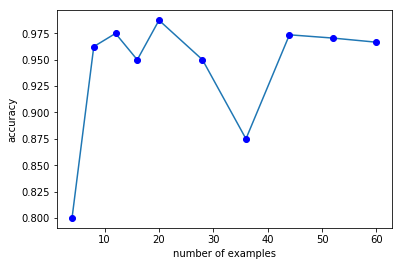

In [45]:
plt.plot(numSamples,accuracy)
plt.plot(numSamples,accuracy,'bo')
#plt.title('Model accuracy by epoch for %d samples per category' % samples_by_category)
plt.ylabel('accuracy')
#plt.legend(['train', 'test'], loc='right')
plt.xlabel('number of examples')
#plt.axis([0, 60, 0, 1])
plt.show()